In [1]:
from glob import iglob
from functools import reduce, partial

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import udf, size, col, lit, explode
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, ArrayType
import matplotlib.pyplot as plt
from numpy import linspace, histogram, histogramdd, array
from numba import jit
from jittedhist import histogram1d, histogram2d

Connect to Spark master

In [2]:
builder = (SparkSession
           .builder
           .appName("PySpark Example")
           .master("spark://carbon.uedalab.local:7077")
           .config("spark.jars.packages", "org.diana-hep:spark-root_2.11:0.1.15")
#            .config("spark.cores.max", 11)
           .config("spark.executor.cores", 4)
           .config("spark.executor.memory", "4g")
           )
spark = builder.getOrCreate()

Read root files

In [3]:
globbed = iglob("/helium/analysis/saito/SortEvent_aq002_t100_nob.root")
loaded = (spark.read.format("org.dianahep.sparkroot").load(fn) for fn in globbed)
df = reduce(DataFrame.unionAll, loaded)
df.printSchema()

root
 |-- SortedEvent: struct (nullable = true)
 |    |-- fEventID: long (nullable = true)
 |    |-- fDetektors: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- fDetektors_fHits: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- fPDNbr: integer (nullable = true)
 |    |    |    |    |    |-- fHitNbr: integer (nullable = true)
 |    |    |    |    |    |-- fU1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fU2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fV1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fV2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fW1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fW2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fMcpNbr: integer (nullable = true)
 |    |    |    |    |    |-- fX_mm: double (nullable = true)
 |    |    |    |    |    |-- fY_mm: double (

Restruct

In [4]:
HitType = StructType([
    StructField('x', DoubleType(), nullable=False),
    StructField('y', DoubleType(), nullable=False),
    StructField('t', DoubleType(), nullable=False),
    StructField('flag', IntegerType(), nullable=False)])


@udf(ArrayType(HitType))
def combine_hits(xarr, yarr, tarr, flagarr):
    return [{'x': x,
             'y': y,
             't': t,
             'flag': f
            } for x, y, t, f in zip(xarr, yarr, tarr, flagarr)]


chits = col('SortedEvent.fDetektors').getItem(0).getField('fDetektors_fHits')
restructed = (df
              .withColumn('hits', combine_hits(chits.getField('fX_mm'),
                                               chits.getField('fY_mm'),
                                               chits.getField('fTime'),
                                               chits.getField('fRekmeth')))
              .select(col('SortedEvent.fEventID').alias("tag"), 'hits'))
restructed.printSchema()

root
 |-- tag: long (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- t: double (nullable = false)
 |    |    |-- flag: integer (nullable = false)



# Out-of-box histogram

Fill

In [5]:
%%time
@udf(ArrayType(ArrayType(DoubleType())))
@jit
def zip_arrays(*arrs):
    return list(zip(*arrs))


hist, xedges, yedges = histogram2d(
    restructed.select(explode(zip_arrays("hits.t", "hits.y"))).rdd.flatMap(array),
    0, 8000, 1000,
    -50, 50, 200)

CPU times: user 1.26 s, sys: 31.2 ms, total: 1.29 s
Wall time: 34.6 s


Plot

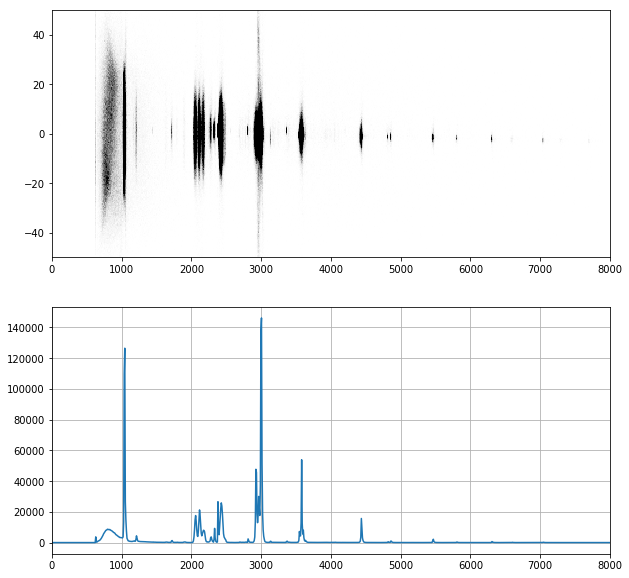

In [6]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.pcolormesh(xedges, yedges, hist[1:-1, 1:-1].T, cmap="Greys")
plt.xlim(0, 8000)
plt.clim(0, 100)

plt.subplot(212)
plt.plot((xedges[1:]+xedges[:-1])/2, hist[1:-1].sum(1))
plt.xlim(0, 8000)
plt.grid(True)
plt.show()

In [7]:
spark.stop()